In [3]:
import torch
from torch_geometric.nn import RGCNConv

# number of nodes = 180000
# input feature size = 512
num_nodes = 180000
in_channels = 512
out_channels = 512   # you can pick the output embedding size
num_relations = 4    # number of edge types

# Fake node features
x = torch.randn((num_nodes, in_channels))

# Fake edge index (COO format) and edge types
# Here we just create a small toy graph with 20k edges
num_edges = 20000
edge_index = torch.randint(0, num_nodes, (2, num_edges), dtype=torch.long)
edge_type = torch.randint(0, num_relations, (num_edges,), dtype=torch.long)

# Define RGCNConv layer
conv = RGCNConv(in_channels, out_channels, num_relations)

# Forward pass
out = conv(x, edge_index, edge_type)

print(out.shape)  # (180000, out_channels)


torch.Size([180000, 512])


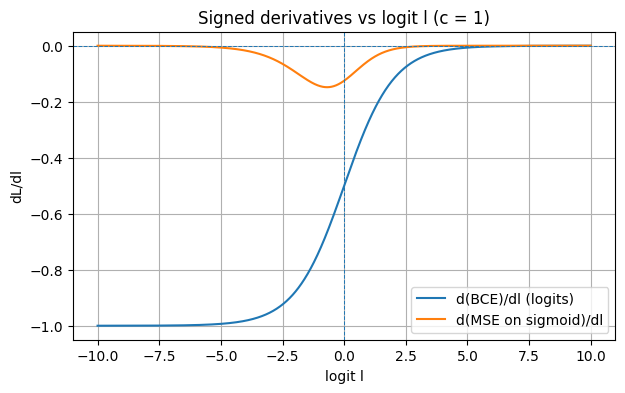

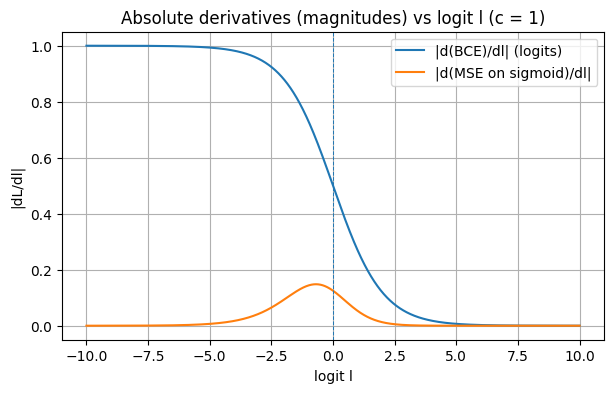

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid
def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

# Wide logit range
l = np.linspace(-10, 10, 2001)  # large enough to approximate -∞ to ∞
s = sigma(l)

# --- Derivatives ---

# BCE (on logits) for c=1
# Loss: log(1 + exp(-l))
# Derivative: -1 / (1 + exp(l))
d_bce = -1.0 / (1.0 + np.exp(l))

# MSE on sigmoid for c=1
# Loss: 0.5 * (sigma(l) - 1)^2
# Derivative: (sigma - 1) * sigma * (1 - sigma)
d_mse = (s - 1.0) * s * (1.0 - s)

# --- Plots ---

plt.figure(figsize=(7,4))
plt.plot(l, d_bce, label='d(BCE)/dl (logits)')
plt.plot(l, d_mse, label='d(MSE on sigmoid)/dl')
plt.axvline(0, linestyle='--', linewidth=0.7)
plt.axhline(0, linestyle='--', linewidth=0.7)
plt.title('Signed derivatives vs logit l (c = 1)')
plt.xlabel('logit l')
plt.ylabel('dL/dl')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(l, np.abs(d_bce), label='|d(BCE)/dl| (logits)')
plt.plot(l, np.abs(d_mse), label='|d(MSE on sigmoid)/dl|')
plt.axvline(0, linestyle='--', linewidth=0.7)
plt.title('Absolute derivatives (magnitudes) vs logit l (c = 1)')
plt.xlabel('logit l')
plt.ylabel('|dL/dl|')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda"
hidden_size = 512
n_x, n_y = 200000, 1024

emb_x = nn.Embedding(n_x, hidden_size).to(device)
emb_y = nn.Embedding(n_y, hidden_size).to(device)

targets = torch.zeros(n_x, n_y, device=device)
pos_x = torch.randint(0, n_x, (n_y,), device=device)
pos_y = torch.arange(n_y, device=device)
targets[pos_x, pos_y] = 1.0

opt = torch.optim.Adam(list(emb_x.parameters()) + list(emb_y.parameters()), lr=1e-3)

def metrics(sim, tgt):
    ranks = torch.argsort(sim, dim=1, descending=True)
    tgt_idx = tgt.argmax(dim=1)
    idx_pos = (ranks == tgt_idx.unsqueeze(1)).nonzero(as_tuple=True)[1] + 1
    r1 = (idx_pos == 1).float().mean().item()
    r10 = (idx_pos <= 10).float().mean().item()
    mrr = (1.0 / idx_pos.float()).mean().item()
    return r1, r10, mrr

scheme = "standard"  # "simplified" or "standard"

N_total = n_x * n_y
N_pos = targets.sum().item()
N_neg = N_total - N_pos

if scheme == "simplified":
    w_pos, w_neg = N_neg / N_pos, 1.0
elif scheme == "standard":
    w_pos, w_neg = N_total / (2 * N_pos), N_total / (2 * N_neg)

combinator = torch.nn.Sequential(
    torch.nn.Linear(2 * hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, 1)
).to(device)

for i in range(1000000):
    x = emb_x(torch.arange(n_x, device=device))
    y = emb_y(torch.arange(n_y, device=device))
    concat = torch.cat([x.unsqueeze(1).expand(-1, n_y, -1), y.unsqueeze(0).expand(n_x, -1, -1)], dim=-1)
    sim = combinator(concat).squeeze(-1)  # (n_x, n_y)
    loss = F.binary_cross_entropy_with_logits(sim, targets, reduction="none")
    weights = torch.where(targets == 1, w_pos, w_neg)
    loss = (loss * weights).mean()
    opt.zero_grad(); loss.backward(); opt.step()
    with torch.no_grad():
        sim_eval = sim[pos_x]                # (n_y, n_y)
        tgt_eval = targets[pos_x]
        r1, r10, mrr = metrics(sim_eval, tgt_eval)
        pos_scores = sim_eval[torch.arange(n_y), pos_y]
        hardest_neg = (sim_eval + tgt_eval * -1e9).max(dim=1).values
        print(f"{i}: {scheme} | loss {loss.item():.4f} | R1 {r1:.3f} R10 {r10:.3f} MRR {mrr:.3f} | pos {pos_scores.mean().item():.3f} hardneg {hardest_neg.mean().item():.3f}")


/home/jp/miniconda3/envs/ReProver/lib/python3.11/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":983, please report a bug to PyTorch. 

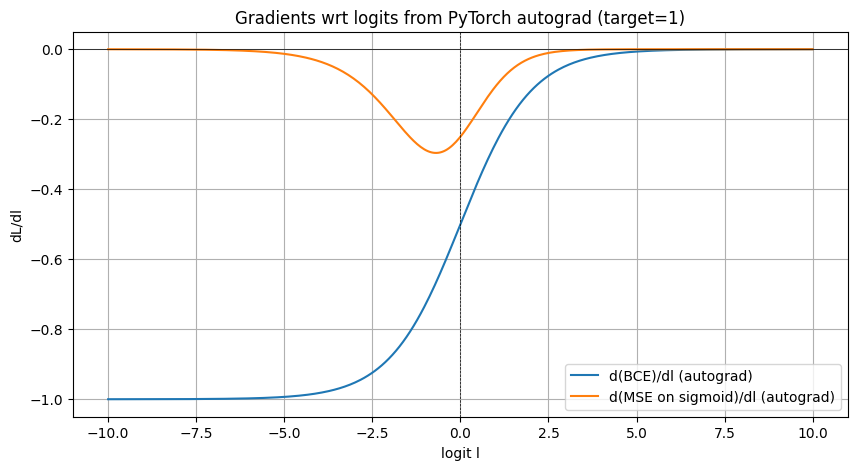

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Make reproducible logits across a wide range
l_values = torch.linspace(-10, 10, 400, requires_grad=True)

# Target = 1
target = torch.ones_like(l_values)

# --- BCEWithLogitsLoss ---
bce_loss_fn = nn.BCEWithLogitsLoss(reduction='none')
bce_loss = bce_loss_fn(l_values, target)   # loss for each logit
# Backprop to get gradients wrt logits
d_bce = torch.autograd.grad(
    bce_loss.sum(), l_values, create_graph=False
)[0].detach()

# --- MSE on sigmoid outputs ---
sigmoid = torch.sigmoid(l_values)
mse_loss_fn = nn.MSELoss(reduction='none')
mse_loss = mse_loss_fn(sigmoid, target)
d_mse = torch.autograd.grad(
    mse_loss.sum(), l_values, create_graph=False
)[0].detach()

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(l_values.detach(), d_bce, label="d(BCE)/dl (autograd)")
plt.plot(l_values.detach(), d_mse, label="d(MSE on sigmoid)/dl (autograd)")
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5, ls='--')
plt.xlabel("logit l")
plt.ylabel("dL/dl")
plt.title("Gradients wrt logits from PyTorch autograd (target=1)")
plt.legend()
plt.grid(True)
plt.show()


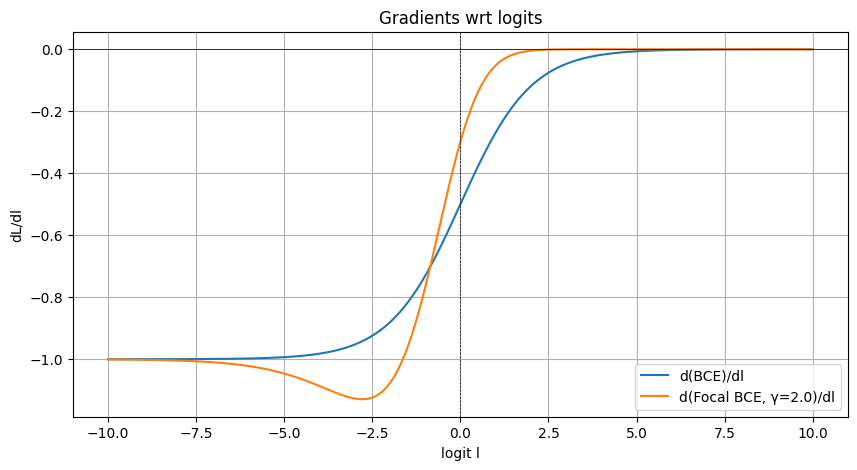

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# logits
l_values = torch.linspace(-10, 10, 400, requires_grad=True)
target = torch.ones_like(l_values)

# --- Standard BCEWithLogitsLoss ---
bce_loss_fn = nn.BCEWithLogitsLoss(reduction='none')
bce_loss = bce_loss_fn(l_values, target)
d_bce = torch.autograd.grad(bce_loss.sum(), l_values)[0].detach()

# --- Focal BCE variant ---
gamma = 2.0
sigmoid = torch.sigmoid(l_values)
focal_loss = ((1 - sigmoid) ** gamma) * nn.functional.binary_cross_entropy_with_logits(
    l_values, target, reduction='none'
)
d_focal = torch.autograd.grad(focal_loss.sum(), l_values)[0].detach()

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(l_values.detach(), d_bce, label="d(BCE)/dl")
plt.plot(l_values.detach(), d_focal, label=f"d(Focal BCE, γ={gamma})/dl")
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5, ls='--')
plt.xlabel("logit l")
plt.ylabel("dL/dl")
plt.title("Gradients wrt logits")
plt.legend()
plt.grid(True)
plt.show()
